# Mask（蒙板）

用蒙板来融合图片，就是把各图层需要擦除的部分设为0，然后利用`opencv`的`add`方法直接相加得到的，所以技巧就在如何把目标部分设为0

通常是把图片变为灰阶，通过试验设定好阈值后，把有形状的部分调成黑色(0)，背景部分设为白色（255）

由于255就是`1111111`，利用`bitwise_and`的特性，另一张图片也处理成白黑后，直接`and`，本图在mask值为0的像素位置将会全部变成0，背景图就准备好了

抠图就要相反，我们把mask反相，即有主体的部分变成白色，与图片进行`and`，那么在需要抠图的区域为0，

现在问题来了，两个`and`生成了两张图片，虽然把需要抠掉的部分都设为了0，但不需要抠的部分也成了1，而不是原色彩，带着问题结合教程进行测试吧先

-------

看代码，每一次融合都有三个对象参与，即原背景，原前景，和mask，也就是说我上面的理解有偏差，确实是对目标图像在mask为零的区域设了0，但在非0的区域不是设1，而是发现是1的时候，用了参数里的另一张图相应像素位置的颜色值。

也就是说，`bitwise_`系列方法并不是只是进行位运算，而以位运算为基础来进行图片的融合。

最后再把抠掉了主体和找掉了背景的两张图进行`add`操作，显然各自抠掉的部分是0，`add`的时候保留的自然是另一张图片的颜色信息了

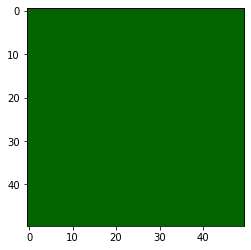

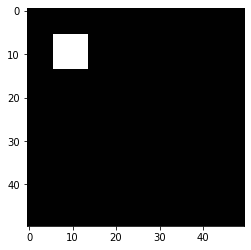

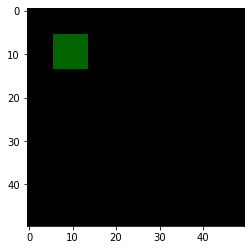

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img1 = np.ones((50,50,3), np.uint8)
img2 = np.ones((50,50,3), np.uint8)
img1[:,:,1:2] = 100 
img2[6:14,6:14,:] = 255
# roi = img1[6:14,6:14,:]

img2gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

# 主体是黑色（用来擦主体）
ret, bg_mask = cv.threshold(img2gray, 190, 255, cv.THRESH_BINARY)
# 主体是白色（用来抠主体）
fg_mask = cv.bitwise_not(bg_mask)

# 如果图1与mask在某像素的bitwise_and值为1，
# 则使用图2在此位置的颜色值（自动）
# 否则就设0 （在后面的add操作中0+别的颜色就成了别的颜色）
# bg = cv.bitwise_and(roi, img2, mask = bg_mask)
bg = cv.bitwise_and(img1, img2, mask = bg_mask)
fg = cv.bitwise_and(img2, img2, mask = fg_mask)

# 形状相等才能相加
# 或者有一方是向量也能相加
# combine = cv.add(bg, fg)
# # 把roi显示到bg上去
# img1[6:14,6:14:] = combine

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
# plt.imshow(cv.add(bg, fg))
plt.imshow(cv.bitwise_and(img1, img2, mask=bg_mask))

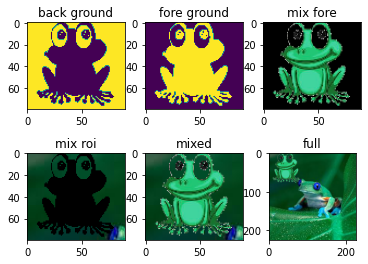

(80, 90, 1)

In [180]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img1 = cv.imread("./img/frog2.jpg")
img2 = cv.imread("./img/frog3.jpg")
# img1 = cv.resize(img1, (330, 330))
# img2 = cv.resize(img2, (90, 90))
img2 = cv.resize(img2, (90, 80))

rows, cols, channels = img2.shape
roi = img1[0:rows, 0:cols, 0:channels]

img3 = np.zeros((rows, cols, channels), np.uint8)
img3[:,:,0] = 255

img2gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

# 主体是黑色，背景是白色(1)，显然可以用来擦除主体(背景用)
ret, mask_bg = cv.threshold(img2gray, 190, 255, cv.THRESH_BINARY)
# 反相用来擦除背景（前景抠图用）
mask_fg = cv.bitwise_not(mask_bg)

mask2 = mask_bg[...,None]
bg = cv.bitwise_and(roi&mask2, roi)
fg = cv.bitwise_and(img2, img2, mask=mask_fg)
img = cv.add(bg, fg)
img1[0:rows, 0:cols] = img

# cv.imshow("senior", img1)
# cv.waitKey(0)

fig, ax = plt.subplots(nrows=2, ncols=3)
fig.subplots_adjust(hspace=.5)
x1, x2, x3, x4, x5, x6 = ax.flatten()
x1.set_title('back ground')
x2.set_title('fore ground')
x3.set_title('mix fore')
x4.set_title('mix roi')
x5.set_title('mixed')
x6.set_title('full')
x1.imshow(mask_bg)
x2.imshow(mask_fg)
x3.imshow(fg)
x4.imshow(bg)
x5.imshow(img)
x6.imshow(img1)
plt.show()

mask_bg[...,None].shape

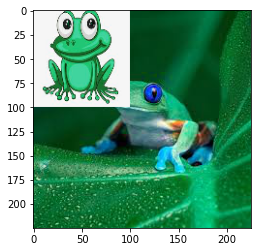

In [137]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# Load two images
img1 = cv.imread("./img/frog2.jpg")
img2 = cv.imread("./img/frog3.jpg")
img2 = cv.resize(img2, (100, 100))
# I want to put logo on top-left corner, So I create a ROI
rows,cols,channels = img2.shape
roi = img1[0:rows, 0:cols]

# Now create a mask of logo and create its inverse mask also
img2gray = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

ret, mask = cv.threshold(img2gray, 10, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)

# Now black-out the area of logo in ROI
img1_bg = cv.bitwise_and(roi,roi,mask = mask_inv)
# Take only region of logo from logo image.
img2_fg = cv.bitwise_and(img2,img2,mask = mask)

# Put logo in ROI and modify the main image
dst = cv.add(img1_bg,img2_fg)
img1[0:rows, 0:cols ] = dst

# cv.imshow('res',img1)
# cv.waitKey(0)
# cv.destroyAllWindows()
plt.imshow(img1)

In [154]:
s = np.array([[[1,2,3],[4,5,6]],[[1,2,3],[4,5,6]]])
s[:,:,0:1] = 10
s

array([[[10,  2,  3],
        [10,  5,  6]],

       [[10,  2,  3],
        [10,  5,  6]]])